In [44]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mp

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from ml.visualization import plot_confusion_matrix, classifier_boundary

np.random.seed(1234)  # Setup seed to be more deterministic


import pandas as pd

%matplotlib inline

(0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)


In [64]:
def regresion_lineal(xtf,yt,xvf,yv,regularizacion,alpha,feature):
    if regularizacion==False:
        model = LinearRegression()
        model.fit(xtf, yt)
    else:
        model = Ridge(alpha=alpha)
        model.fit(xtf, yt)
 
    err_train = mean_squared_error(yt, model.predict(xtf))
    err_val = mean_squared_error(yv, model.predict(xvf)) 
        
    return [feature,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def regresion_polinomial(xtf,yt,xvf,yv,grado_polinomio,regularizacion,alpha,feature):
    poly_features = PolynomialFeatures(grado_polinomio)
    poly_features.fit(xtf)
    X_poly_train = poly_features.transform(xtf)
    X_poly_val = poly_features.transform(xvf)
    
    if regularizacion==False:
        model = LinearRegression()
        model.fit(X_poly_train, y_train)

    else:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train, y_train)        

    err_train = mean_squared_error(y_train, model.predict(X_poly_train))
    err_val = mean_squared_error(y_val, model.predict(X_poly_val))
    
    return [feature,grado_polinomio,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def modelo(x,coef,x0):
    ymodel = np.zeros(len(x))
    for i in range(len(x)):
        if len(coef)==1:
            ymodel[i] = coef[0]*x[i]
        else:
            for c in range(len(coef)):
                ymodel[i] = ymodel[i] + coef[c]*x[i]**c
    return ymodel+x0


def plot_fit(feature_resultados,tipo,c):    
    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])

    X_linspace = np.linspace(X_range_start, X_range_stop, 200)
    
    # Conjunto de entrenamiento
    plt.scatter(X_train_feature, y_train, facecolor="lightgray", edgecolor="gray", label="datos",s=4.8)
    if tipo=='L':
        for j in range(len(feature_resultados)):
            coef = feature_resultados.Coef.values[j]
            x0 = feature_resultados.Intercept.values[j]
            plt.plot(X_linspace, modelo(X_linspace,coef,x0), color=c, label="modelo",lw=1)
            plt.title("Conjunto de Entrenamiento Reg-Lin")
    elif tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            for j in range(len(sub_df)):
                coef = sub_df.Coef.values[j]
                x0 = sub_df.Intercept.values[j]
                plt.plot(X_linspace, modelo(X_linspace,coef,x0),color=c[cc],label="modelo",lw=1)
                plt.title("Conjunto de Entrenamiento Reg-Pol")
            cc+=1
            
    plt.ylim(y_range_start, y_range_stop)
    
    # Conjunto de validación
    #plt.subplot(1, 2, 2)
    #plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    #plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
    #plt.ylim(y_range_start, y_range_stop)
    #plt.title("Conjunto de Validación")
    
def plot_err(feature_resultados,tipo,c):
    if tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            plt.plot(sub_df.Alpha,sub_df.TrainMSE,color=c[cc],label='Grado: '+str(g))
            cc+=1                
        plt.legend(loc='lower right',frameon=False,ncol=3)
    elif tipo=='L':
        plt.plot(feature_resultados.Alpha,feature_resultados.TrainMSE,color=c)
    plt.xlabel('alpha')
    plt.ylabel('ECM')

In [3]:
boston_data = load_boston()

In [46]:
regresion_lineal_ECM = pd.DataFrame(columns=['Feature','Regularization','Alpha','TrainMSE', 'ValMSE','Coef','Intercept'])
regresion_polinomial_ECM = pd.DataFrame(columns=['Feature','Degree','Regularization','Alpha','TrainMSE','ValMSE','Coef','Intercept'])


shuff_data = np.random.permutation(506)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = boston_data['data'][shuff_train]
X_val = boston_data['data'][shuff_val]

y_train = boston_data['target'][shuff_train]
y_val = boston_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(boston_data['feature_names'])}

features = boston_data['feature_names']
categorical_features = ['CHAS','RAD','MEDV']
non_categorical_features = set(features)-set(categorical_features)

#alpha = np.arange(0.1, 1.1, 0.1)
grado = np.arange(2,10,1)
alpha = np.arange(1e-5,1e3,10)

cmap = mp.cm.get_cmap('Spectral')
color = []
for i in range(len(grado)):
    color.append(cmap(0.1*i))

for feature in non_categorical_features:
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    # regresion lineal
    ## sin regularizacion
    row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,False,0,feature)
    regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    ## con regularizacion
    for i in alpha:
        row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,True,i,feature)
        regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    

    # regresion polinomial
    ## sin regularizacion
    for g in grado:
        row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,False,0,feature)
        regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)
    ## con regularizacion
        for i in alpha:
            row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,True,i,feature)
            regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.73215e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8466e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.31738e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.2733e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.55698e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.01031e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.07777e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.14523e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.2127e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.28016e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.69597e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.83817e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.98051e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.12299e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.2656e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.25326e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.40147e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.54978e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.69818e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.84668e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.07351e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.4359e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.79829e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.16069e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.52308e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.16728e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.19755e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.22785e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.25822e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.28848e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.40881e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.58516e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.76151e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.93786e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.11422e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.02835e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.06381e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.09928e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13474e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.1702e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01414e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.0496e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.08506e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.12052e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.15598e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.93064e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.00578e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.08092e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.15607e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.23121e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.98844e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.06358e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.13873e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.21387e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.28902e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.81291e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.97484e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.13677e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.29869e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.46062e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.49094e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.50713e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.52332e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.53952e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.55571e-33): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.34772e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.38319e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.41865e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.45412e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48958e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.26285e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.29832e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.33378e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.36925e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.40472e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.91721e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.99605e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.07489e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.15374e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.23258e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.09591e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.17475e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.25359e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.33244e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.41128e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.6172e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.79134e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.96548e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.13961e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.31375e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.51499e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.5324e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.54982e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.56723e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.58465e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.21684e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26191e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.30698e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.35205e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.39711e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.65052e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.69559e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.74066e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.78573e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.8308e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.36885e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.63881e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.90877e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.17873e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.4487e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.10571e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.13271e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.1597e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.1867e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.21369e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.9241e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.08761e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.25111e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.41462e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.57812e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.19358e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.20993e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.22628e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24263e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.25898e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.69631e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.79609e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.89587e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.99566e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.09544e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.78523e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.88501e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.98479e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.08458e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.18436e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.04107e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.10231e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.16355e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.22478e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.28602e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.73559e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.79683e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.85807e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.91931e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.98055e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.30466e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.68215e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.05963e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.43711e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.8146e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.60464e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.64239e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.68014e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.71789e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.75564e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.81033e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.51619e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.65477e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.47046e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.29765e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.18051e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.27861e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.37672e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.47482e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.57292e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.62089e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.09953e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.23697e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37441e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.51185e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.36812e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.47686e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.58563e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.6944e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.80319e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.67192e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.56255e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.45319e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13438e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.32345e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.64461e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.7977e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.95095e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.10438e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.25798e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.4374e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.45338e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.46937e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48538e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.50141e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.05023e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.19411e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.33799e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.48187e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.62575e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.5049e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.78772e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.07054e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.35336e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.63618e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.00803e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.03632e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.0646e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.09288e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.12116e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.32877e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.87753e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.04263e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.0975e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.15238e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.3804e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.42709e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.47379e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.5205e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.56722e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37287e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.47848e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.56932e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.65621e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.74319e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.19679e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.2868e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.37688e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.46703e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.55724e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.27426e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.44353e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.6132e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.78326e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.95372e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.29308e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.31328e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.33349e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.35369e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37389e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.05979e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.43894e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.81846e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.01983e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.05786e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.96971e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01275e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.05579e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.09883e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.14187e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.57356e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.95469e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.33582e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.71695e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.09808e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.09621e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.13433e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.17244e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.21055e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.24867e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.69696e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.73507e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.77318e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.26213e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.74294e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.85941e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.89203e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.92466e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.95728e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.9899e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.28945e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.50707e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.72462e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.94212e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.15959e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80434e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.82631e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.84829e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.87028e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.89227e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.45107e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.6154e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.77974e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.94408e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.10841e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.03532e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.05175e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.06819e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.08462e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.10105e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.44318e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.64514e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.8471e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.04907e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.25103e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.29057e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.30891e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.32725e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.3456e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.36394e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.99789e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.21274e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.4276e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.64247e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.85736e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.91249e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.93404e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.9556e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.97716e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.99872e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.14523e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.17002e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.19482e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.21962e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24443e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.19185e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.21691e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.24196e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.26703e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.2921e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.41014e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.4389e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.46768e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.7091e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.74135e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.86405e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.19662e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.41316e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.6581e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.26738e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.25087e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.40099e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.55105e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.70104e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.85098e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.94483e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.96488e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.98493e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8919e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.85156e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.64761e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.83414e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.02066e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.20719e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.39372e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.90067e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.90067e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.80133e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.702e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.60266e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.72431e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.90296e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.08163e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.26029e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.43896e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.94549e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.89098e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.83647e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.68204e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.48138e-29): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.10444e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.12251e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.14057e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.15864e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.1767e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.65962e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.84265e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.02574e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.2089e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.39211e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.59544e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.61538e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.63532e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.65527e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.67521e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.76878e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.97322e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.17766e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.3821e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.58654e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.98308e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.00353e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.02397e-35): result may not be accurate.
  overwrite_a=True).T


PTRATIO


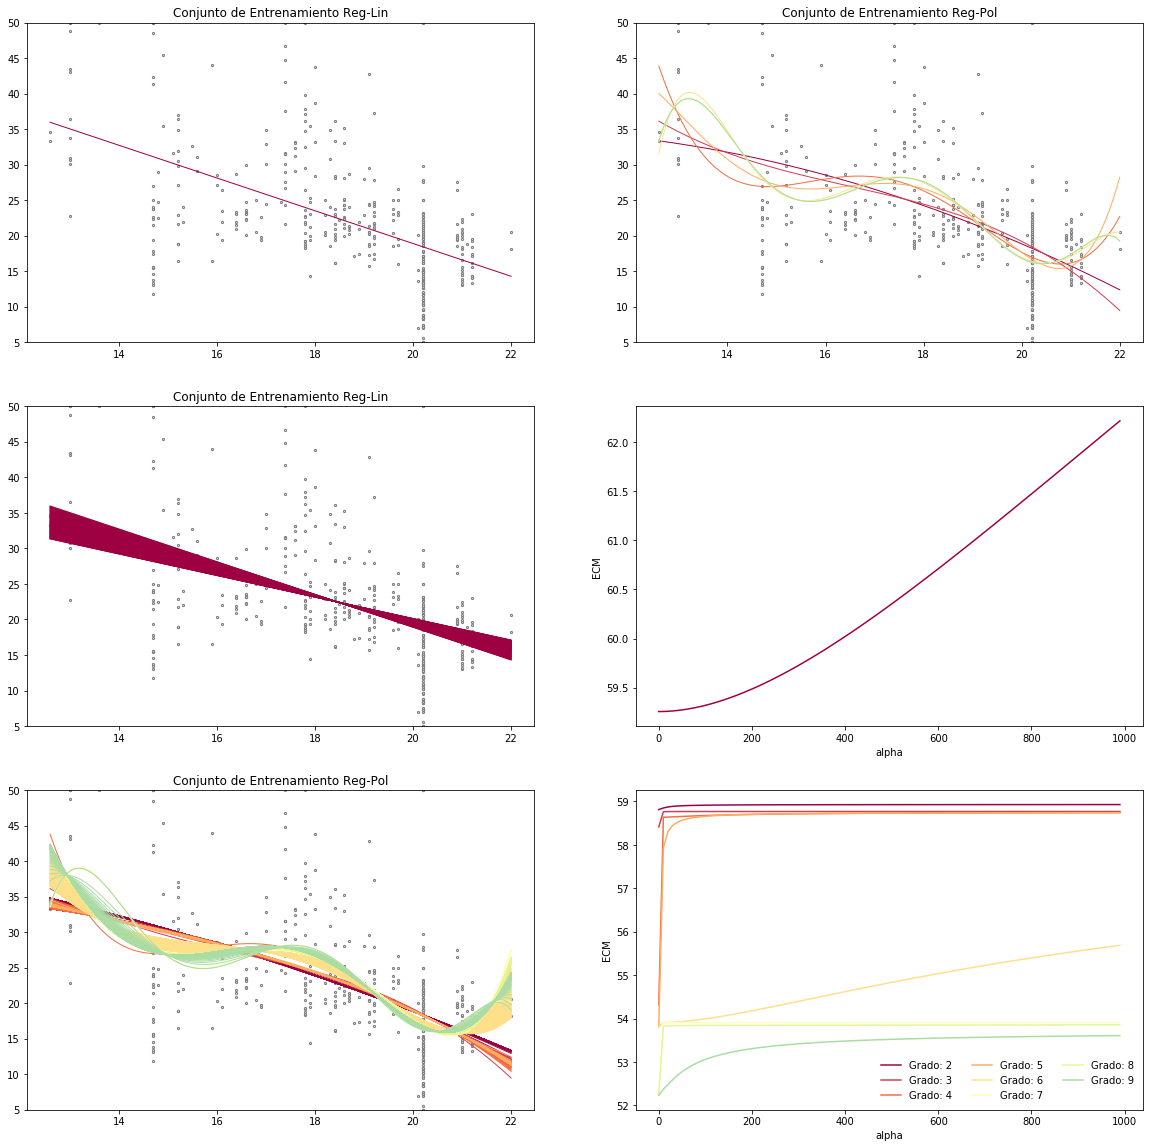

TAX


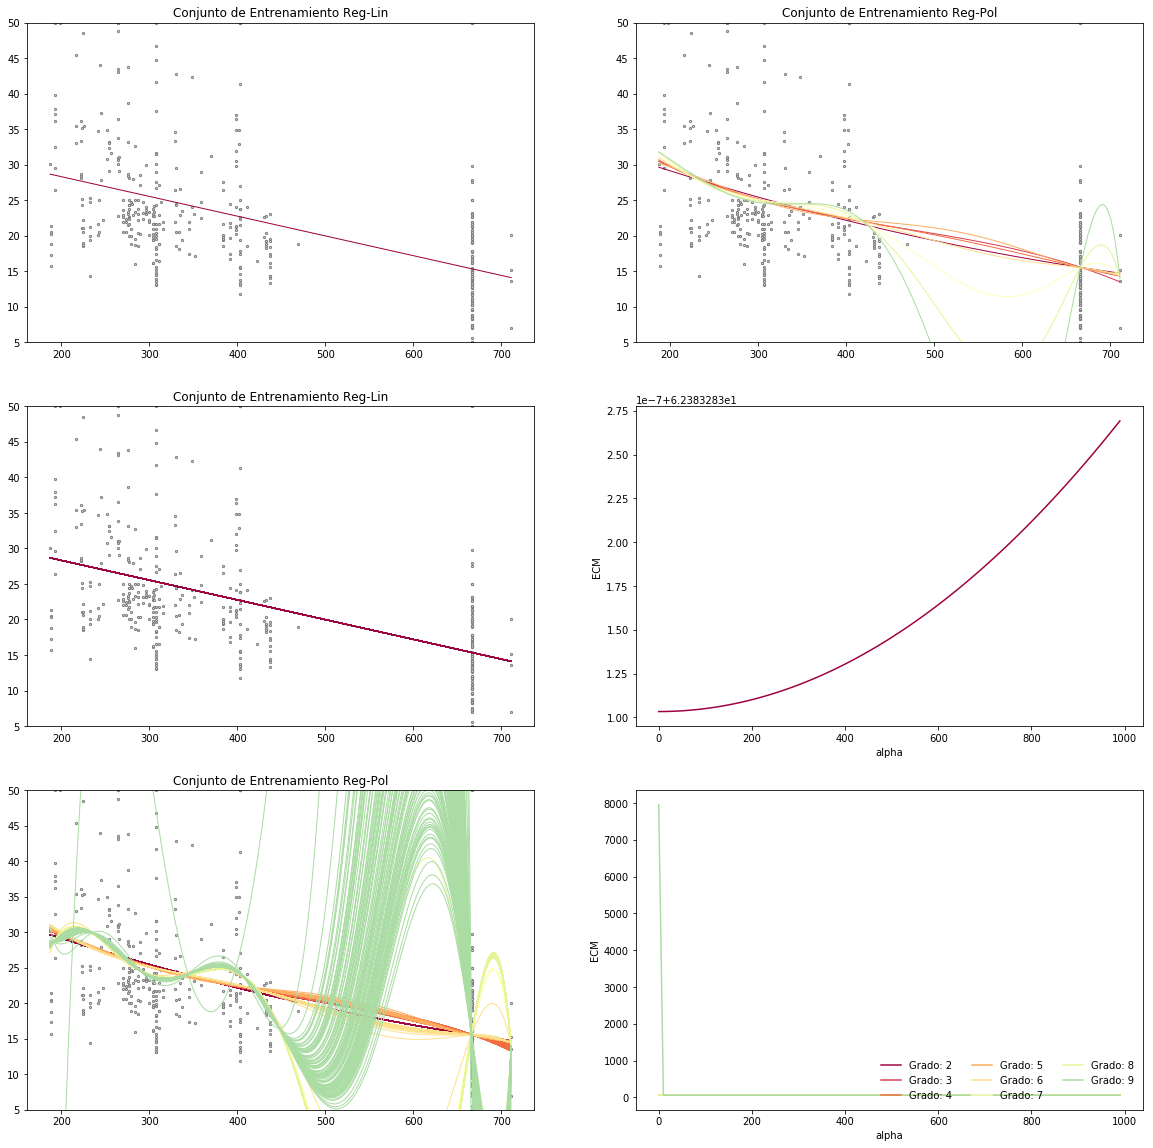

B


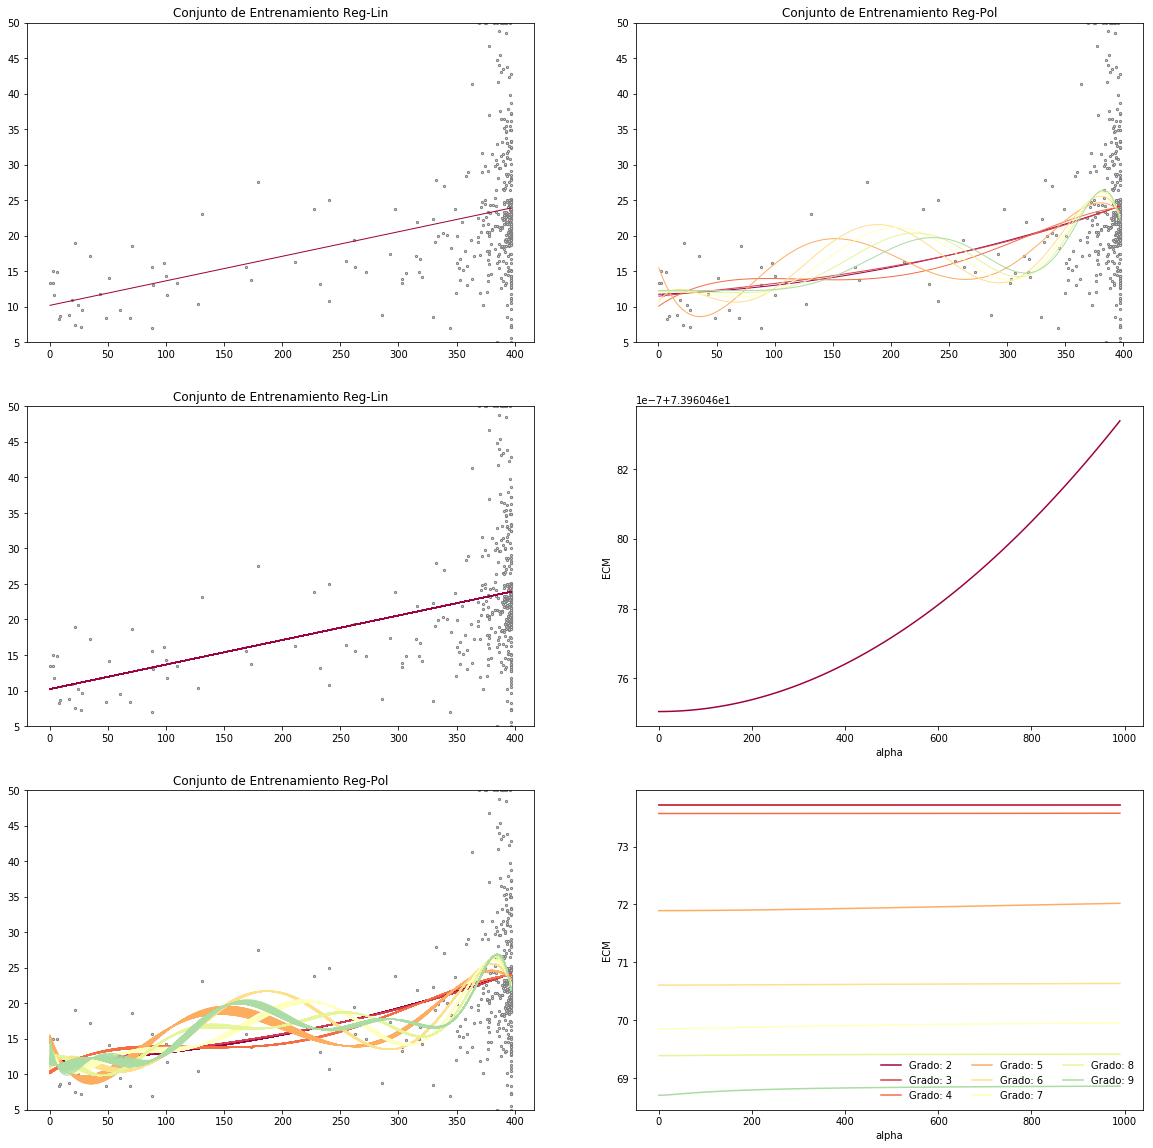

NOX


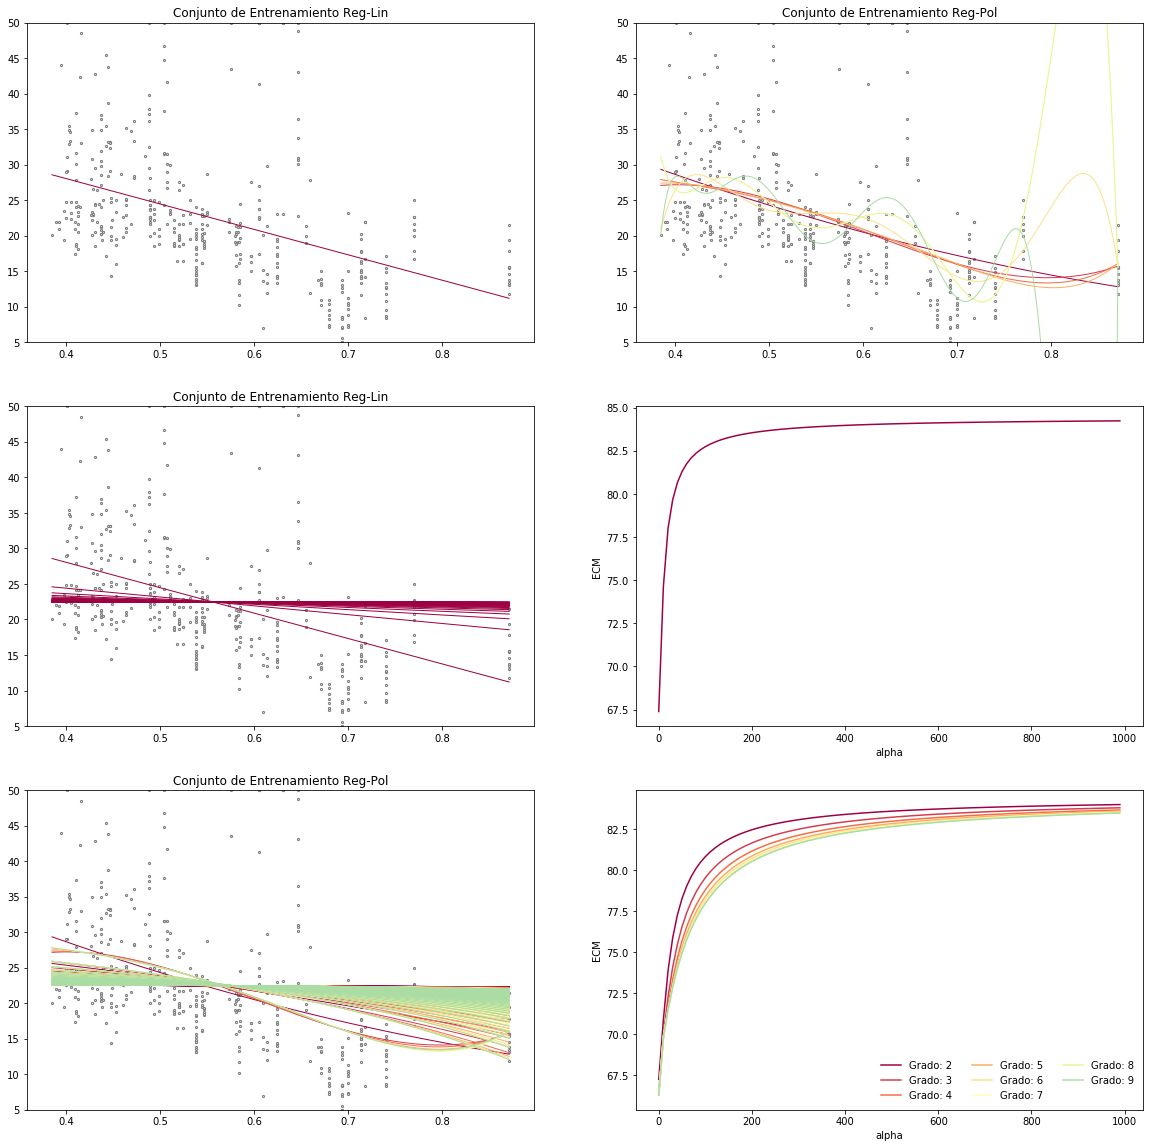

INDUS


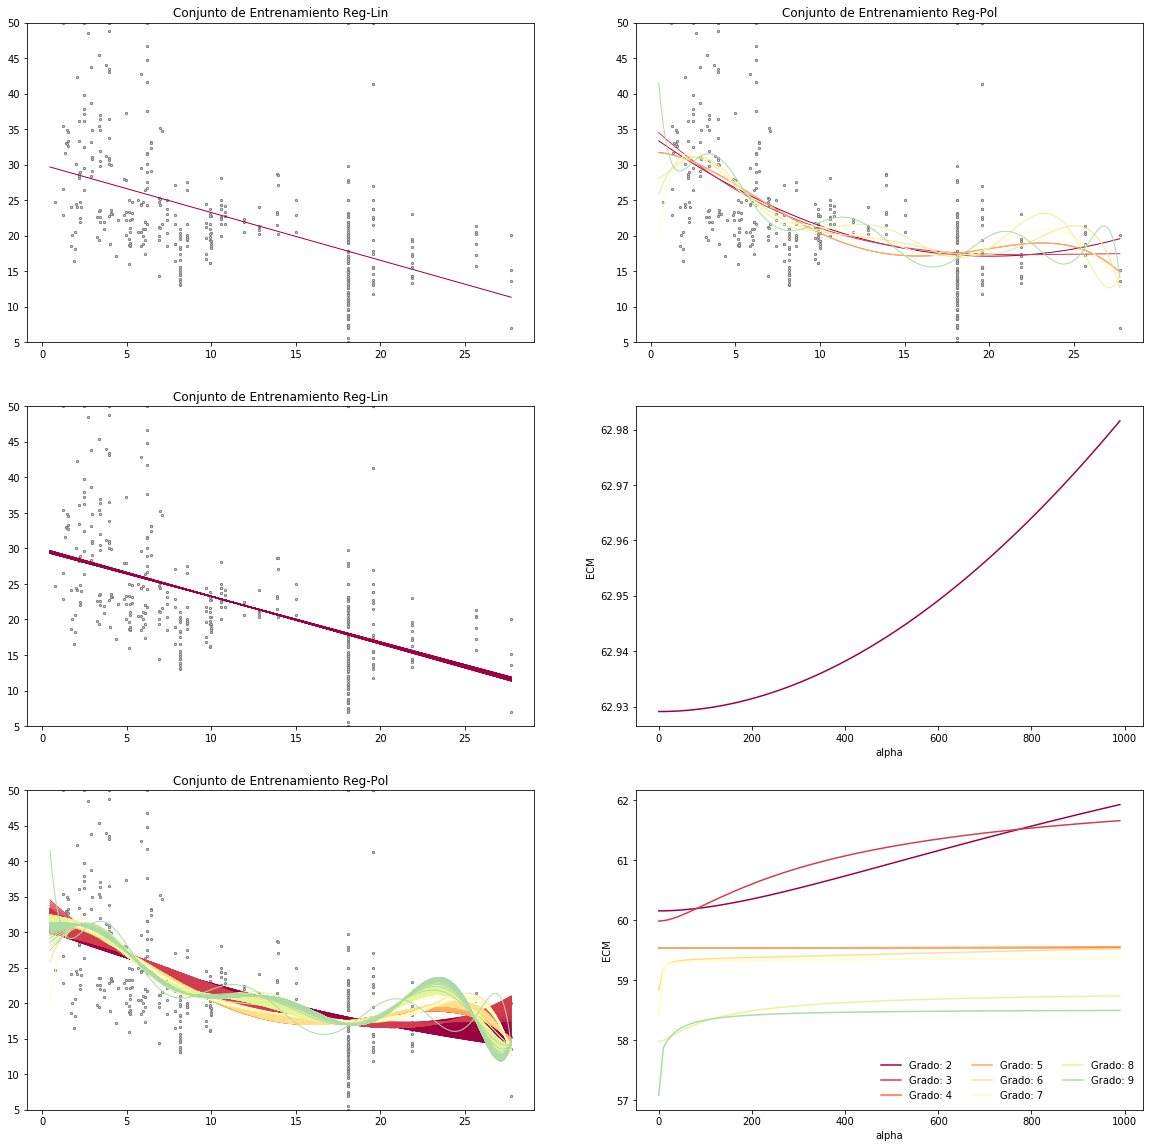

CRIM


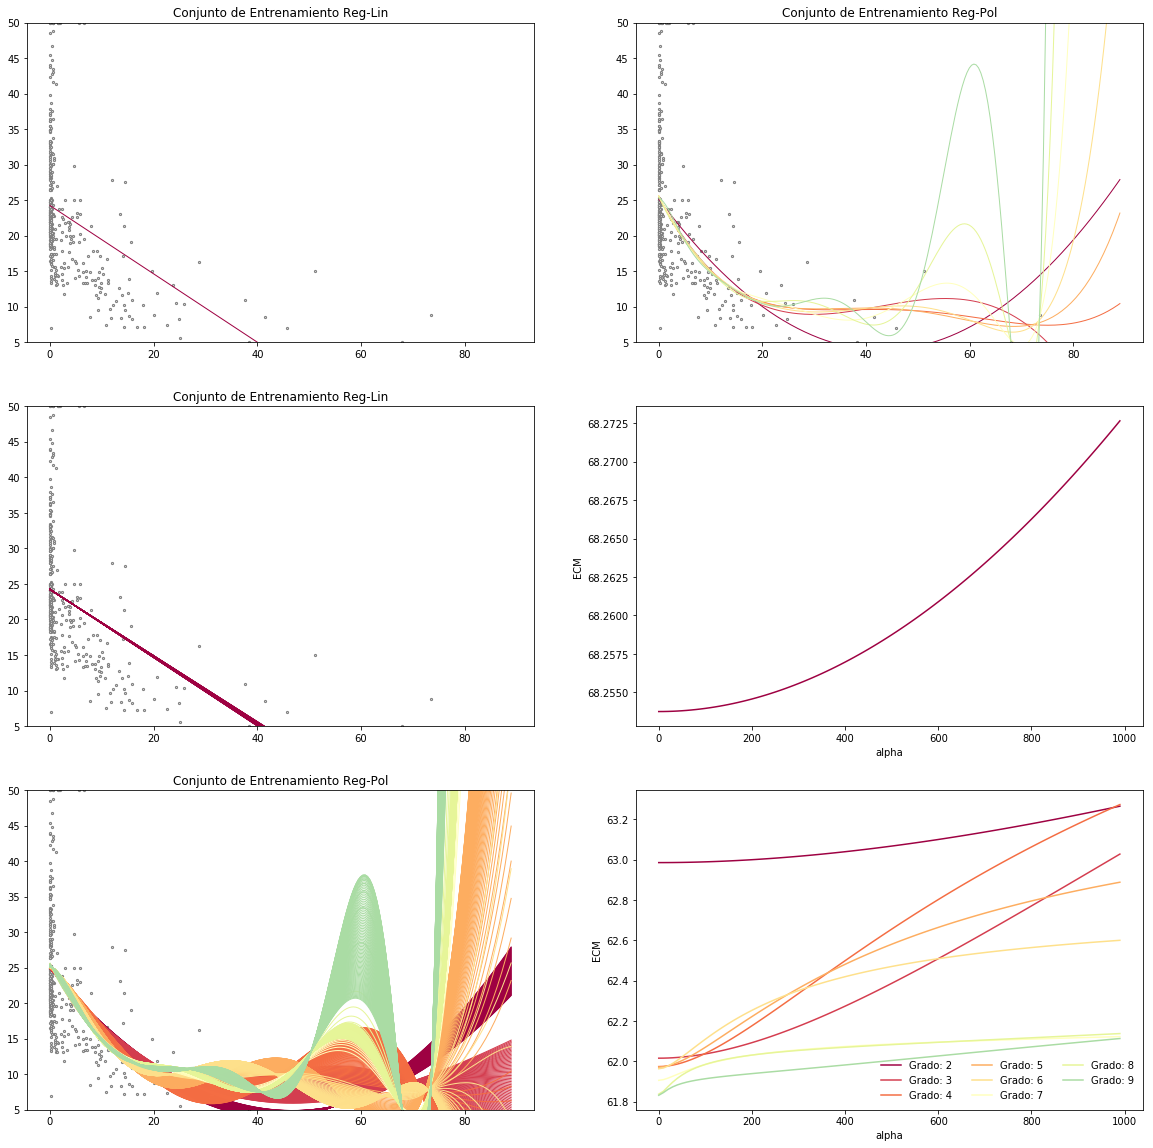

LSTAT


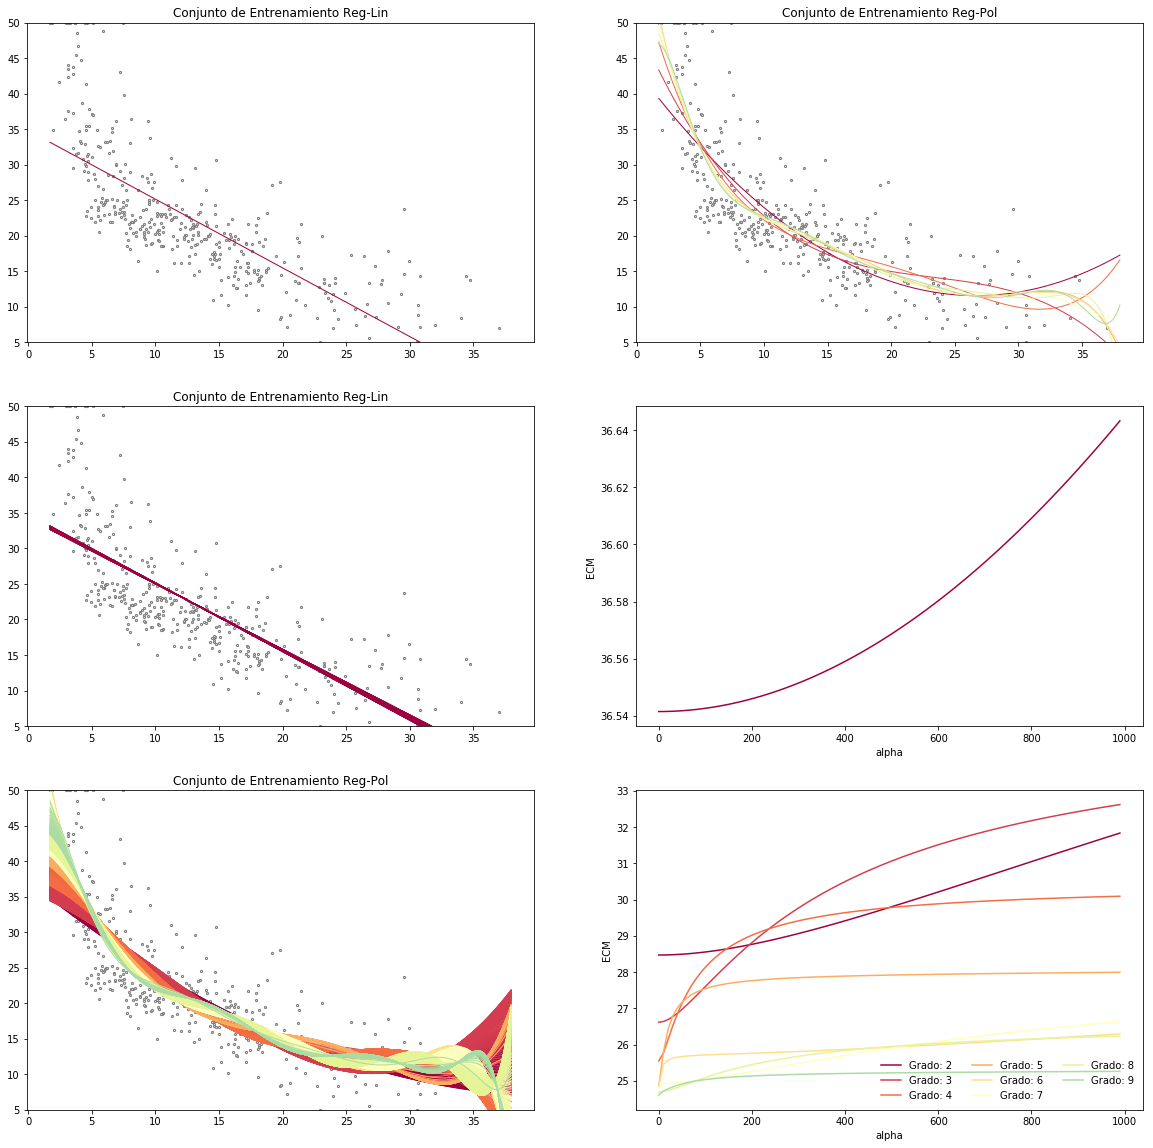

RM


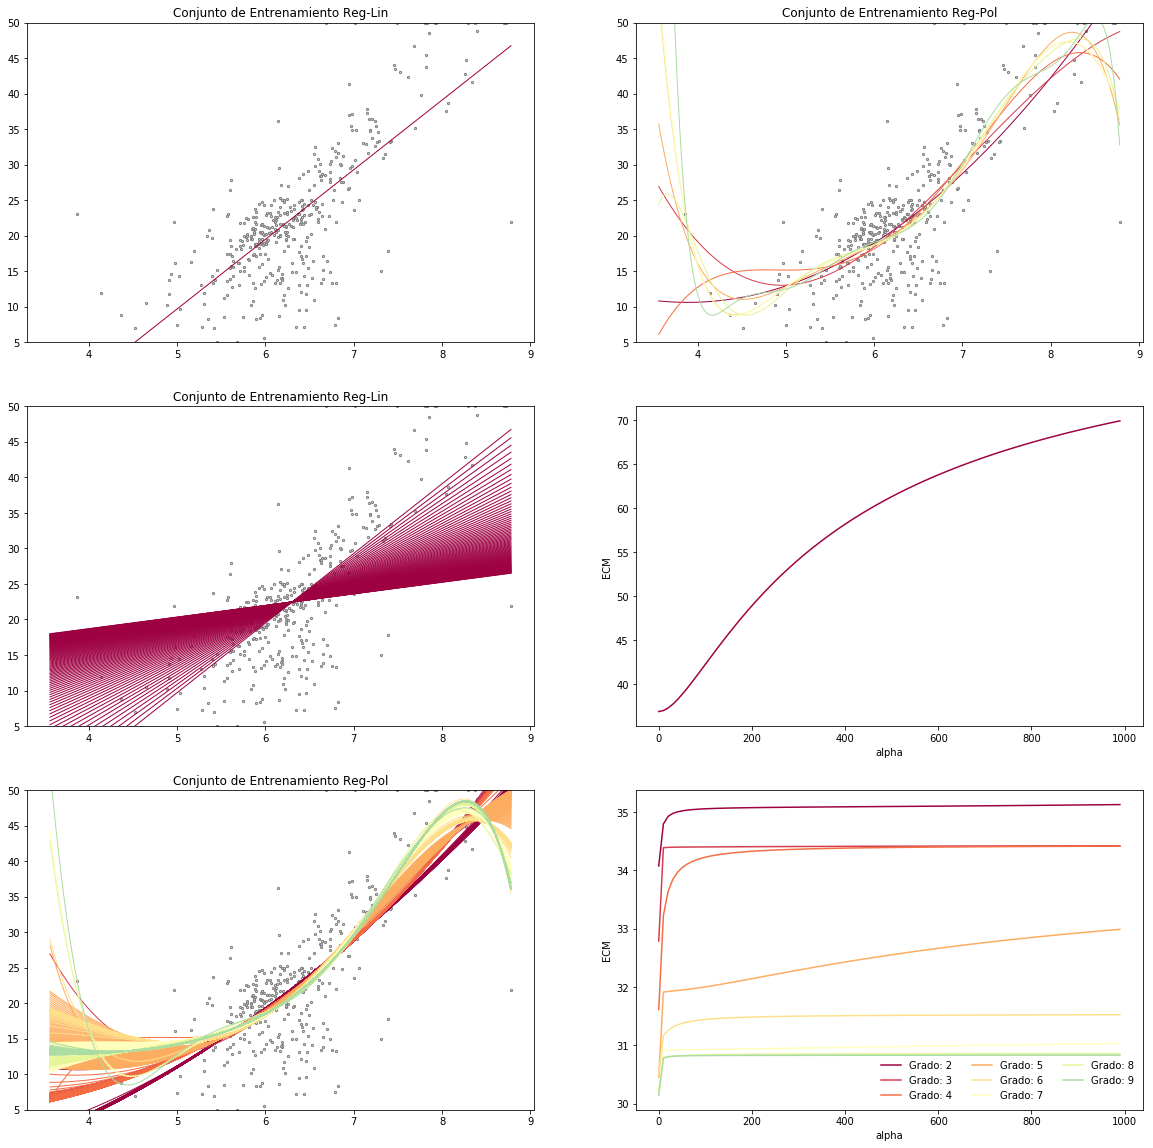

ZN


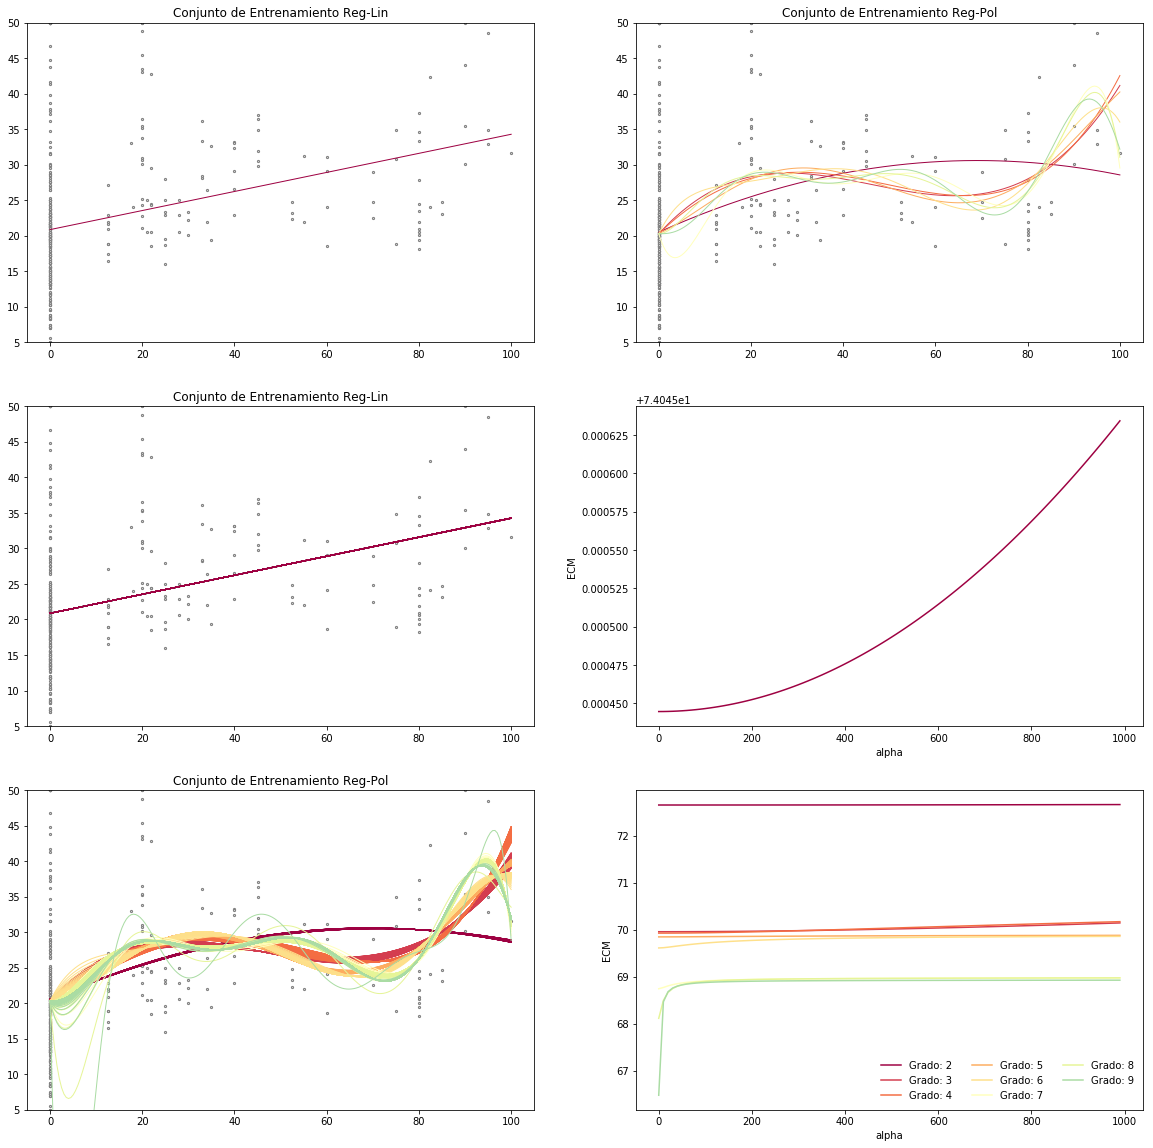

DIS


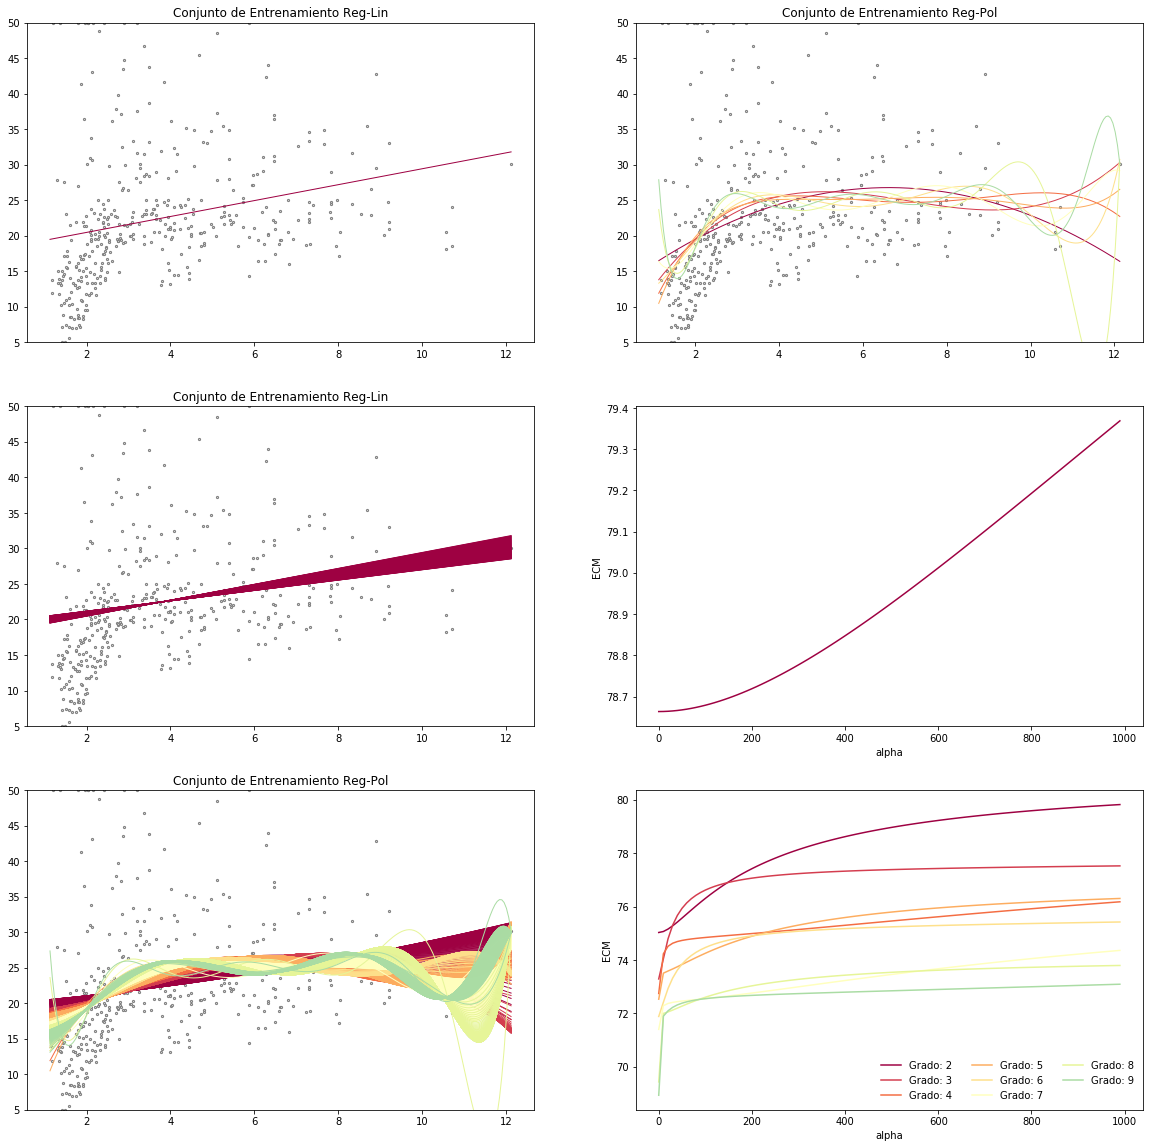

AGE


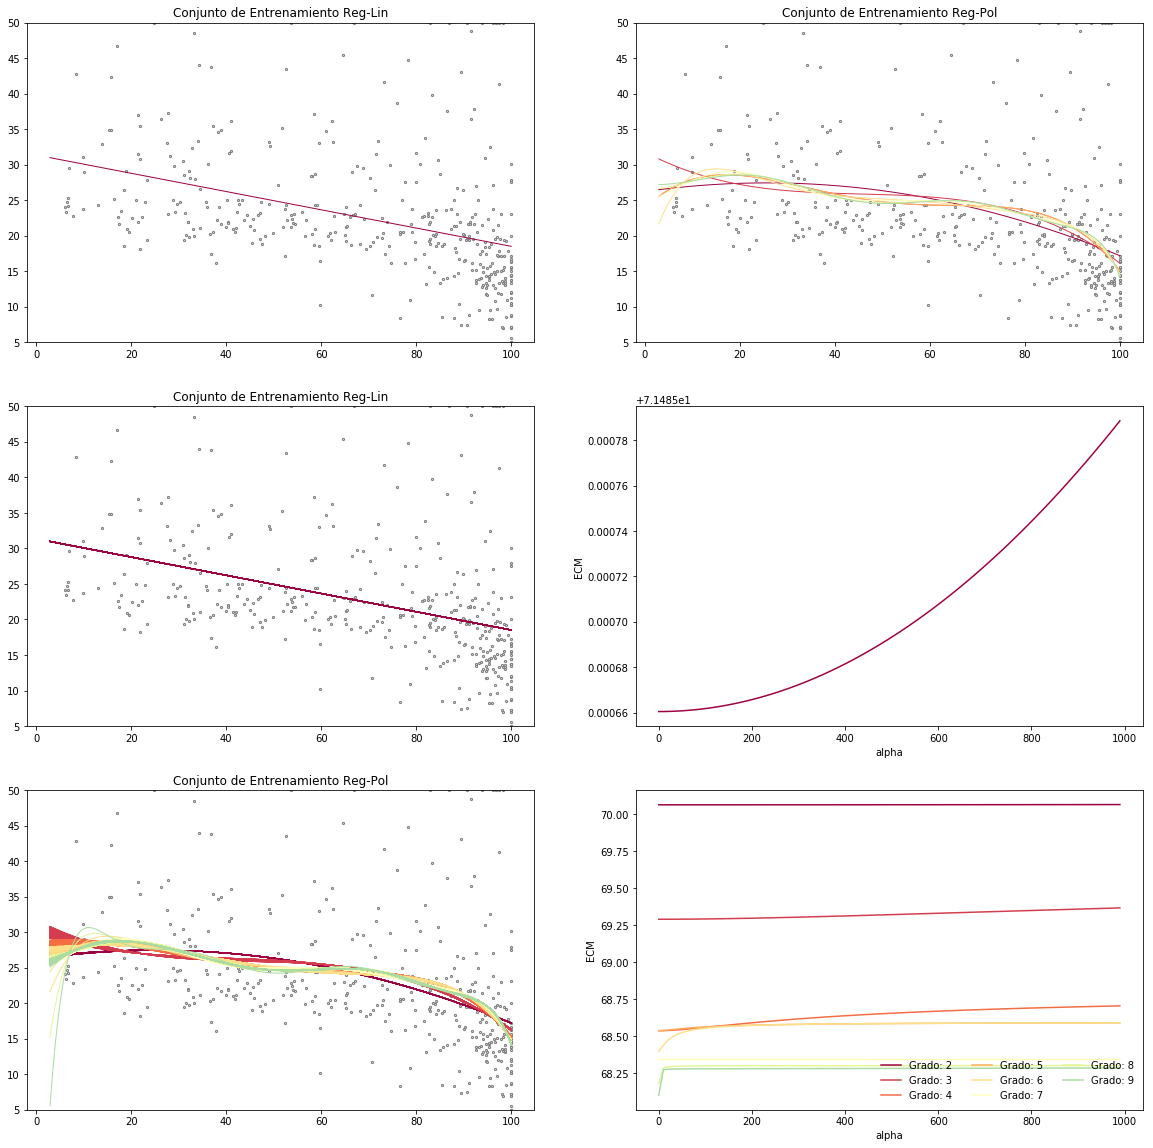

In [65]:
for feature in non_categorical_features:
    print(feature)
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    plt.figure(figsize=(20,20))
    
    feature_resultados = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                               (regresion_lineal_ECM.Regularization==False)]
    plt.subplot(321)
    plot_fit(feature_resultados,'L',color[0])

    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==False)]
    plt.subplot(322)
    plot_fit(feature_resultados,'P',color)
    
    feature_resultados = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                             (regresion_lineal_ECM.Regularization==True)]
    
    plt.subplot(323)
    plot_fit(feature_resultados,'L',color[0])
    plt.subplot(324)
    plot_err(feature_resultados,'L',color[0])
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==True)]
    plt.subplot(325)
    plot_fit(feature_resultados,'P',color)
    plt.subplot(326)
    plot_err(feature_resultados,'P',color)
    
    plt.show()

In [21]:
feature_resultados


,Feature,Degree,Regularization,Alpha,TrainMSE,ValMSE,Coef,Intercept
1,PTRATIO,2,True,1e-05,65.544900,50.292700,"[0.0, 2.1875210591443235, -0.12352756349980379]",24.690419
2,PTRATIO,2,True,10,65.574262,50.273303,"[0.0, 0.935729057376547, -0.08802711703878281]",35.532218
3,PTRATIO,2,True,20,65.592440,50.278330,"[0.0, 0.5946943683102691, -0.07835528959282907]",38.485863
4,PTRATIO,2,True,30,65.602411,50.282186,"[0.0, 0.4355980465345816, -0.07384314267755178]",39.863723
5,PTRATIO,2,True,40,65.608616,50.284857,"[0.0, 0.34350511913958304, -0.07123117830687631]",40.661261
6,PTRATIO,2,True,50,65.612833,50.286773,"[0.0, 0.28345062609599003, -0.06952780781189528]",41.181311
7,PTRATIO,2,True,60,65.615882,50.288202,"[0.0, 0.24119294989984227, -0.0683291460878635]",41.547221
8,PTRATIO,2,True,70,65.618187,50.289307,"[0.0, 0.20984202537763944, -0.067439794354163]",41.818667
9,PTRATIO,2,True,80,65.619991,50.290185,"[0.0, 0.18565792617148807, -0.06675369018155235]",42.028040
10,PTRATIO,2,True,90,65.621440,50.290898,"[0.0, 0.16643522724882653, -0.06620828882607695]",42.194442
